## Select all image

### 패키지 다운로드

In [1]:
import glob, os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D, Dropout, concatenate, BatchNormalization, AveragePooling2D, concatenate,Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

### 데이터 다운로드

In [25]:
dir_data = "C:/Users/Jeong Eun/Desktop/input/dataA/dataA"
dir_seg = dir_data + "/CameraSeg/"
dir_img = dir_data + '/CameraRGB/'
all_img_paths = glob.glob(os.path.join(dir_img, '*.png'))
all_img_paths[:5]

['C:/Users/Jeong Eun/Desktop/input/dataA/dataA/CameraRGB\\02_00_000 (2).png',
 'C:/Users/Jeong Eun/Desktop/input/dataA/dataA/CameraRGB\\02_00_000.png',
 'C:/Users/Jeong Eun/Desktop/input/dataA/dataA/CameraRGB\\02_00_001.png',
 'C:/Users/Jeong Eun/Desktop/input/dataA/dataA/CameraRGB\\02_00_010 (2).png',
 'C:/Users/Jeong Eun/Desktop/input/dataA/dataA/CameraRGB\\02_00_010.png']

In [26]:
all_mask_paths = glob.glob(os.path.join(dir_seg, '*.png'))
all_mask_paths[:5]

['C:/Users/Jeong Eun/Desktop/input/dataA/dataA/CameraSeg\\02_00_000 (2).png',
 'C:/Users/Jeong Eun/Desktop/input/dataA/dataA/CameraSeg\\02_00_000.png',
 'C:/Users/Jeong Eun/Desktop/input/dataA/dataA/CameraSeg\\02_00_001 (2).png',
 'C:/Users/Jeong Eun/Desktop/input/dataA/dataA/CameraSeg\\02_00_001.png',
 'C:/Users/Jeong Eun/Desktop/input/dataA/dataA/CameraSeg\\02_00_010 (2).png']

In [28]:
x = []
y = []
count=0

for i in range(len(all_img_paths)):
  img = cv2.imread(all_img_paths[i])
  img = cv2.resize(img,(64,64))
  mask_path = dir_seg+all_img_paths[i].split('\\')[-1]
  img_mask = imageio.imread(mask_path)   # Changed to skimage read
  img_mask = cv2.resize(img_mask,(64,64))
  x.append(img)
  y.append(img_mask)
  if(i%100==0):
    print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [29]:
print(np.array(y).shape)
print(np.array(x).shape)

(1999, 64, 64, 3)
(1999, 64, 64, 3)


### 마스크 이미지(자동차 구분)으로 학습

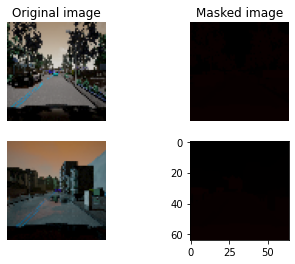

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(221)
plt.imshow(x[250])
plt.axis('off')
plt.title('Original image')
plt.grid('off')
plt.subplot(222)
plt.imshow(y[250])
plt.axis('off')
plt.title('Masked image')
plt.grid('off')
plt.subplot(223)
plt.imshow(x[100])
plt.axis('off')
plt.grid('off')
plt.subplot(224)
plt.imshow(y[100])

plt.show()

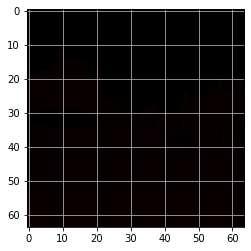

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img_mask)
plt.grid('off')
plt.show()

### y=10 : 자동차

(array([9207.,  683.,   60.,   33.,   21.,   22.,   46.,  735.,  313.,
        1168.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

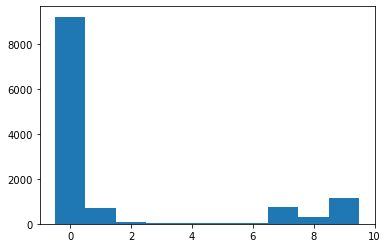

In [32]:
import matplotlib.pyplot as plt
x = np.array(x)
y = np.array(y)
plt.hist(y[2].flatten(),align='left')

In [33]:
y1 = np.where(y==10,1.,0.)
y1.shape

(1999, 64, 64, 3)

In [34]:
x = np.array(x)
y2 = np.array(y1)[:,:,:,0]
y2 = y2.reshape(y2.shape[0],y2.shape[1],y2.shape[2],1)
print(x.shape, y2.shape)

(1999, 64, 64, 3) (1999, 64, 64, 1)


In [35]:
x = x/255
print(np.max(x))

1.0


### CNN 모델 구축을 위한 패키지

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D, Dropout, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import glob, os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D, Dropout, concatenate, BatchNormalization, AveragePooling2D, concatenate,Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16


In [36]:
base_vgg16 = VGG16(input_shape =  (64,64,3), include_top = False, weights = 'imagenet')
base_vgg16.trainable = False
conv1 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block1_conv2').output).output
conv2 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block2_conv2').output).output
conv3 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block3_conv3').output).output
drop3 = Dropout(0.5)(conv3)
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(UpSampling2D(size =(2,2))(drop3))
merge8 = concatenate([conv2,up8],axis = -1)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)
up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(UpSampling2D(size =(2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = -1)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',  kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)
branch_a=Conv2D(64,1,activation='relu',strides=2)(conv9)
branch_b=Conv2D(64,1,activation='relu')(conv9)
branch_b=Conv2D(64,3, activation='relu',padding='same',strides=2)(branch_b)
branch_c=Conv2D(64,5,activation='relu',padding='same')(conv9)
branch_c=Conv2D(64,3,activation='relu',padding='same')(branch_c)
branch_c=Conv2D(64,3,activation='relu',padding='same',strides=2)(branch_c)
concatenated=concatenate([branch_a,branch_b,branch_c],axis=-1)
up9 = Conv2D(64, 12, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(UpSampling2D(size =(2,2))(concatenated))
out1=BatchNormalization()(up9)
out = Conv2D(1, 1, activation = 'sigmoid')(out1)
model = Model(inputs = base_vgg16.input, outputs = out)

In [37]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 32, 32, 64)   0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [38]:
for layer in model.layers[:18]:
  layer.trainable = False

In [39]:
model.compile(optimizer=Adam(1e-3, decay = 1e-6), 
                   loss='binary_crossentropy', metrics = ['accuracy'])

In [40]:
history = model.fit(x,y2,epochs=10,batch_size=1,validation_split=0.1)

Epoch 1/10
1799/1799 [==============================] - 2756s 2s/step - loss: 0.0707 - accuracy: 0.9779 - val_loss: 0.0278 - val_accuracy: 0.9920
Epoch 2/10
1799/1799 [==============================] - 2673s 1s/step - loss: 0.0369 - accuracy: 0.9876 - val_loss: 0.0641 - val_accuracy: 0.9746
Epoch 3/10
1799/1799 [==============================] - 2931s 2s/step - loss: 0.0330 - accuracy: 0.9887 - val_loss: 0.0170 - val_accuracy: 0.9959
Epoch 4/10
1799/1799 [==============================] - 2762s 2s/step - loss: 0.0267 - accuracy: 0.9907 - val_loss: 0.0184 - val_accuracy: 0.9954
Epoch 5/10
1799/1799 [==============================] - 2778s 2s/step - loss: 0.0228 - accuracy: 0.9920 - val_loss: 0.0278 - val_accuracy: 0.9920
Epoch 6/10
1799/1799 [==============================] - 2800s 2s/step - loss: 0.0208 - accuracy: 0.9929 - val_loss: 0.0249 - val_accuracy: 0.9940
Epoch 7/10
1799/1799 [==============================] - 2830s 2s/step - loss: 0.0182 - accuracy: 0.9936 - val_loss: 0.0284 -

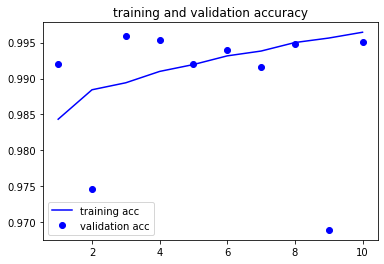

In [41]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

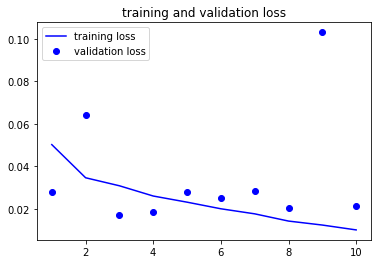

In [42]:
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [59]:
y_pred = model.predict(x[-300:])
#np.mean(y_predi == y_testi)

In [44]:
y_pred.shape

(2, 64, 64, 1)

### 테스트 데이터로 마스크 이미지 학습이 잘 되는지 확인

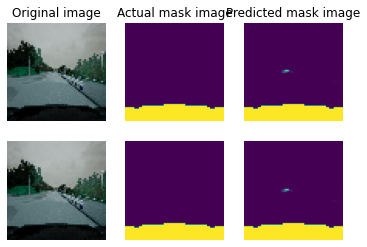

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(231)
plt.imshow(x[-1])
plt.axis('off')
plt.title('Original image')
plt.grid('off')
plt.subplot(232)
plt.imshow(y2[-1,:,:,0])
plt.axis('off')
plt.title('Actual mask image')
plt.grid('off')
plt.subplot(233)
plt.imshow(y_pred[-1,:,:,0])
plt.axis('off')
plt.title('Predicted mask image')
plt.grid('off')
plt.subplot(234)
plt.imshow(x[-2])
plt.axis('off')
plt.grid('off')
plt.subplot(235)
plt.imshow(y2[-2,:,:,0])
plt.axis('off')
plt.grid('off')
plt.subplot(236)
plt.imshow(y_pred[-2,:,:,0])
plt.axis('off')
plt.grid('off')
plt.show()

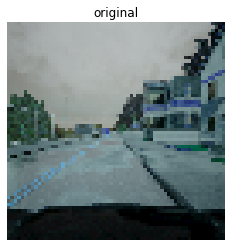

In [54]:
plt.imshow(x[-300])
plt.title('original')
plt.axis('off')
plt.grid('off')



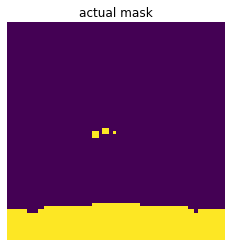

In [55]:
plt.title('actual mask')
plt.imshow(y2[-300,:,:,0])
plt.axis('off')
plt.grid('off')



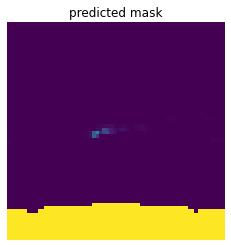

In [60]:
plt.imshow(y_pred[-300,:,:,0])
plt.axis('off')
plt.grid('off')
plt.title('predicted mask')
plt.show()

In [58]:
y_pred.shape

(2, 64, 64, 1)

### 격자 무늬 만들기, 자동차가 있는 칸에서 알림 띄우기

In [61]:
from PIL import Image

In [68]:
import numpy as np
from PIL import Image

im = y_pred[-300,:,:,0]
pix = np.array(im)
print(np.round(im,3))
block=np.round(im,2)

[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.002 0.001 0.001]
 [0.    0.    0.    ... 0.003 0.001 0.001]
 ...
 [1.    1.    1.    ... 1.    1.    1.   ]
 [1.    1.    1.    ... 1.    1.    1.   ]
 [1.    1.    1.    ... 1.    1.    1.   ]]


In [87]:
block1=block[:16,:16]
block2=block[:16,16:32]
block3=block[:16,32:48]
block4=block[:16,48:64]
block5=block[16:32:16]
block6=block[16:32,16:32]
block7=block[16:32,32:48]
block8=block[16:32,48:64]
block9=block[32:48,:16]
block10=block[32:48,16:32]
block11=block[32:48,32:48]
block12=block[32:48,48:64]
block13=block[48:64,:16]
block14=block[48:64,16:32]
block15=block[48:64,32:48]
block16=block[48:64,48:64]

In [97]:
len(block2>0)

16

In [147]:
print((block1>0).sum())
print((block2>0).sum())
print((block3>0).sum())
print((block4>0).sum())
print((block5>0).sum())
print((block6>0).sum())
print((block7>0).sum())
print((block8>0).sum())
print((block9>0).sum())
print((block10>0).sum())
print((block11>0).sum())
print((block12>0).sum())
print((block13>0).sum())
print((block14>0).sum())
print((block15>0).sum())
print((block16>0).sum())

0
0
0
1
0
14
20
8
3
13
4
4
146
167
167
148


In [126]:
blocklist=[[block1, block2, block3, block4, block5, block6, block7, block8, block9,
            block10, block11, block12, block13, block14, block15, block16]]

In [164]:
print((block1>0.1).sum())
print((block2>0.1).sum())
print((block3>0.1).sum())
print((block4>0.1).sum())
print((block5>0.1).sum())
print((block6>0.1).sum())
print((block7>0.1).sum())
print((block8>0.1).sum())
print((block9>0.1).sum())
print((block10>0.1).sum())
print((block11>0.1).sum())
print((block12>0.1).sum())
print((block13>0.1).sum())
print((block14>0.1).sum())
print((block15>0.1).sum())
print((block16>0.1).sum())

0
0
0
0
0
2
0
0
0
7
0
0
146
167
167
148


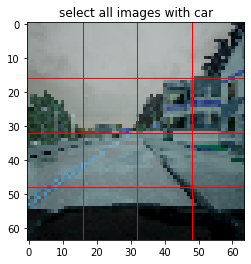

In [172]:
plt.imshow(x[-300])
plt.title('select all images with car')
plt.axhline(y=16, color='r', linewidth=1)
plt.axhline(y=32, color='r', linewidth=1)
plt.axhline(y=48, color='r', linewidth=1)
plt.axvline(x=16, color='r', linewidth=1)
plt.axvline(x=32, color='r', linewidth=1)
plt.axvline(x=48, color='r', linewidth=1)


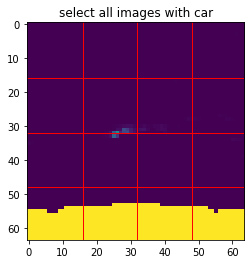

In [173]:
plt.imshow(y_pred[-300,:,:,0])
plt.title('select all images with car')
plt.axhline(y=16, color='r', linewidth=1)
plt.axhline(y=32, color='r', linewidth=1)
plt.axhline(y=48, color='r', linewidth=1)
plt.axvline(x=16, color='r', linewidth=1)
plt.axvline(x=32, color='r', linewidth=1)
plt.axvline(x=48, color='r', linewidth=1)